## TELECOM CHURN PREDICTION 

#### Importing Libraries

In [1]:
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.types import DecimalType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import LongType
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
from pyspark import SparkContext
import pyspark.sql 

sc = SparkContext(appName="PythonStreamingQueueStream")   
sqlContext = SQLContext(sc)

In [3]:
data = sqlContext.read.load('telecom_users.csv',format='com.databricks.spark.csv', header = True, inferSchema='true')

In [4]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
data = data.drop('_c0').drop('customerID')

In [6]:
cols = data.columns
cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [7]:
pd.DataFrame(data.take(5), columns = data.columns)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [8]:
data.groupby('StreamingMovies').count().toPandas()

,StreamingMovies,count
0,No,2356
1,Yes,2339
2,No internet service,1291


In [9]:
Categorical_ = [item[0] for item in data.dtypes if item[1].startswith('string')]
Numerical_ = [item[0] for item in data.dtypes if item[1] == 'int' or item[1] == 'double']

In [10]:
stages=[]
for categoricalCol in Categorical_:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols = [categoricalCol + 'classVec'])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = [c + 'classVec' for c in Categorical_] + Numerical_
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features')
stages += [assembler]

In [11]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['label', 'features'] + cols
data = data.select(selectedCols)
data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
data.toPandas().head(5)

,label,features,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,"(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,0.0,"(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,1.0,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,0.0,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,0.0,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [13]:
train, test = data.randomSplit([0.1,0.9], seed = 472)
print("Training Dataset :" + str(train.count()))
print("Testing Dataset :" + str(test.count()))

Training Dataset :610
Testing Dataset :5376


In [14]:
%%time
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 2)
lrModel = lr.fit(train)

Wall time: 1.84 s


In [15]:
lr_summary = lrModel.summary

In [16]:
lr_summary.accuracy

0.940983606557377

In [17]:
lr_summary.areaUnderROC

0.9999856354860952

In [18]:
lr_summary.precisionByLabel

[0.9271255060728745, 1.0]

In [19]:
lr_summary.recallByLabel

[1.0, 0.7631578947368421]

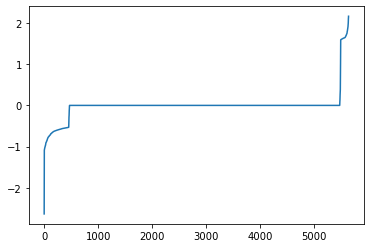

In [20]:
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.show()

In [21]:
pred = lrModel.transform(test)
pred.select('label','prediction').toPandas()

,label,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
5371,1.0,0.0
5372,1.0,0.0
5373,1.0,0.0
5374,1.0,0.0


In [22]:
label = pred.select('label').toPandas()
prediction = pred.select('prediction').toPandas()

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(label, prediction)

array([[3941,    0],
       [1113,  322]], dtype=int64)

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(label,prediction)

0.79296875

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier

In [26]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [27]:
dt_model = dt.fit(train)

In [28]:
predictions = dt_model.transform(test)

In [29]:
label = predictions.select('label').toPandas()
prediction = predictions.select('prediction').toPandas()

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(label,prediction)

1.0

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(label, prediction)

array([[3941,    0],
       [   0, 1435]], dtype=int64)

In [32]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [33]:
lsvcModel = lsvc.fit(train)

In [34]:
predictions = lsvcModel.transform(test)

In [35]:
label = predictions.select('label').toPandas()
prediction = predictions.select('prediction').toPandas()

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(label,prediction)

0.9034598214285714

In [37]:
svm.precisionByLabel

NameError: name 'svm' is not defined

In [ ]:
svm.accuracy

In [ ]:
svm.areaUnderROC